# Notebook 03: Drift & Jitter Detection

**Goal:** Detect *slow trends (drift)* and *noisy/jittery periods* that a simple z‑score may miss. This notebook:
1) generates or loads labeled synthetic data,
2) implements a rolling **slope-based drift detector**,
3) implements a **jitter/high-variance detector** using rolling std,
4) evaluates precision/recall/F1,
5) (optional) loads best params from Notebook 02 and shows a simple ensemble.

> Plots use `matplotlib` with one chart per figure (no specific colors).

In [23]:

import os, sys, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make repo root importable when running from notebooks/
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import IsolationForest

from src.sim import simulate_temperature_series
from src.features import add_rolling_features, make_windowed_matrix

plt.rcParams["figure.figsize"] = (12, 4)
pd.set_option("display.max_rows", 200)


In [24]:

# 1) Data: generate fresh (with ground truth) or load a saved CSV
USE_SAVED = False  # set True if you want to reuse processed CSV

if USE_SAVED:
    path = "../data/processed/simulated_with_flags.csv"  # adjust if needed
    df = pd.read_csv(path)
    if "is_anomaly" not in df.columns:
        raise ValueError("CSV must include 'is_anomaly' ground-truth labels.")
else:
    df = simulate_temperature_series(n=10_000, base_temp=100.0, noise_sigma=0.2, seed=7)

y_true = df["is_anomaly"].astype(int).values
df.head()


,t,temp,is_anomaly,anomaly_type
0,0,100.000246,False,none
1,1,100.059749,False,none
2,2,99.945172,False,none
3,3,99.821882,False,none
4,4,99.909066,False,none


In [25]:

def compute_prf1(y_true, y_pred, valid_mask=None):
    """Return precision, recall, f1 (binary). Optionally ignore invalid rows via mask."""
    if valid_mask is None:
        valid_mask = np.ones_like(y_pred, dtype=bool)
    pr, rc, f1, _ = precision_recall_fscore_support(
        y_true[valid_mask], y_pred[valid_mask], average="binary", zero_division=0
    )
    return pr, rc, f1


## 2) Drift detector via rolling slope
Intuition: fit a tiny line to the last *w* points; if the absolute slope is large, we call it drift.
We set a *robust* threshold using the median and MAD (median absolute deviation).

In [26]:

def rolling_slope(x: np.ndarray, w: int) -> np.ndarray:
    """Compute slope of least-squares line over trailing window of length w for each t.
    Returns array of length len(x) with NaN for the first w-1 positions."""
    n = len(x)
    a = np.full(n, np.nan, dtype=float)
    t = np.arange(n, dtype=float)
    for i in range(w-1, n):
        ti = t[i-w+1:i+1]
        yi = x[i-w+1:i+1]
        denom = np.var(ti)
        if denom == 0:
            continue
        a[i] = np.mean((ti - ti.mean()) * (yi - yi.mean())) / denom
    return a

def robust_abs_threshold(values: np.ndarray, k: float = 5.0) -> float:
    """Threshold on |values| using median + k*MAD (MAD is median absolute deviation)."""
    v = np.abs(values.copy())
    med = np.nanmedian(v)
    mad = np.nanmedian(np.abs(v - med))
    return med + k * mad

# Params you can tune
w_slope = 200
slope = rolling_slope(df["temp"].values, w=w_slope)
tau_slope = robust_abs_threshold(slope, k=5.0)
drift_pred = (np.abs(slope) >= tau_slope).astype(int)

valid = ~np.isnan(slope)
pr, rc, f1 = compute_prf1(y_true, drift_pred, valid_mask=valid)
print(f"Drift detector (w={w_slope}, tau≈{tau_slope:.4e}) -> Precision={pr:.3f} Recall={rc:.3f} F1={f1:.3f}")


Drift detector (w=200, tau≈1.2776e-03) -> Precision=0.852 Recall=0.904 F1=0.877


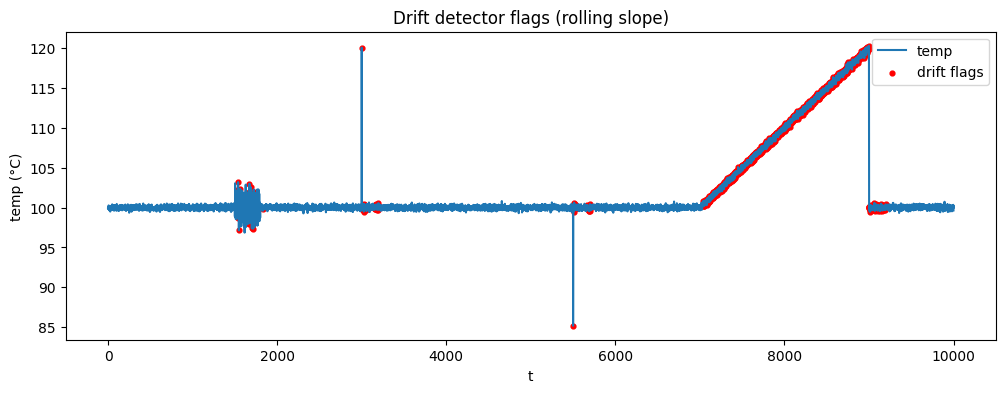

In [27]:

plt.figure()
plt.plot(df["t"], df["temp"], label="temp")
plt.scatter(df.loc[drift_pred == 1, "t"], df.loc[drift_pred == 1, "temp"], s=12, label="drift flags", marker="o", color = "red")
plt.title("Drift detector flags (rolling slope)")
plt.xlabel("t"); plt.ylabel("temp (°C)"); plt.legend(); plt.show()


## 3) Jitter / high-variance detector
Intuition: compute rolling standard deviation; if it spikes well above normal, flag jittery intervals.

In [28]:

def rolling_std_flag(x: np.ndarray, w: int, mult: float = 3.0):
    s = pd.Series(x).rolling(w).std(ddof=0).to_numpy()
    med = np.nanmedian(s)
    mad = np.nanmedian(np.abs(s - med))
    tau = med + mult * mad
    pred = (s >= tau).astype(int)
    return pred, tau, s

w_std = 80
jitter_pred, tau_std, rolling_std = rolling_std_flag(df["temp"].values, w=w_std, mult=4.0)
valid_std = ~np.isnan(rolling_std)
pr, rc, f1 = compute_prf1(y_true, jitter_pred, valid_mask=valid_std)
print(f"Jitter detector (w={w_std}, tau≈{tau_std:.4f}) -> Precision={pr:.3f} Recall={rc:.3f} F1={f1:.3f}")


Jitter detector (w=80, tau≈0.2687) -> Precision=0.876 Recall=0.947 F1=0.910


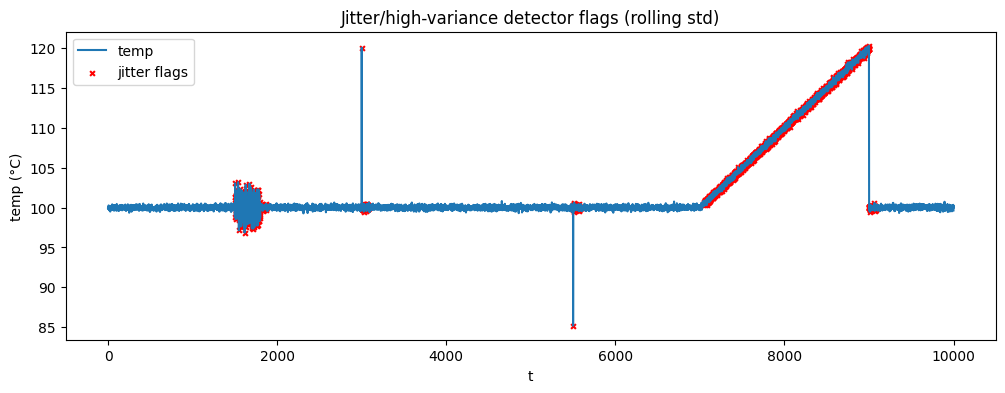

In [29]:

plt.figure()
plt.plot(df["t"], df["temp"], label="temp")
plt.scatter(df.loc[jitter_pred == 1, "t"], df.loc[jitter_pred == 1, "temp"], s=12, label="jitter flags", marker="x", color = "red")
plt.title("Jitter/high-variance detector flags (rolling std)")
plt.xlabel("t"); plt.ylabel("temp (°C)"); plt.legend(); plt.show()


## 4) (Optional) Simple ensemble with tuned baselines
If you ran Notebook 02, we can load `best_params.json`, recompute rule & Isolation Forest predictions, and OR them with drift/jitter to see the combined effect.

In [30]:

rule_preds = np.zeros(len(df), dtype=int)
if_preds = np.zeros(len(df), dtype=int)

try:
    with open("../data/processed/best_params.json", "r") as f:
        best = json.load(f)

    # Rule
    w_rule = int(best["rule"]["window"]); thr = float(best["rule"]["thresh"])
    df_r = add_rolling_features(df, window=w_rule)
    z = df_r[f"zscore_{w_rule}"].values
    rule_preds = (np.abs(z) >= thr).astype(int)

    # Isolation Forest
    w_if = int(best["iforest"]["window"])
    X = make_windowed_matrix(df["temp"].values, window=w_if)
    if len(X) > 0:
        iso = IsolationForest(n_estimators=int(best["iforest"]["n_estimators"]),
                              contamination=float(best["iforest"]["contam"]),
                              random_state=42)
        iso.fit(X)
        preds = iso.predict(X)
        start = w_if // 2
        centers = np.arange(start, start + len(X))
        if_preds[centers] = (preds == -1).astype(int)
    print("Loaded best_params.json and computed rule/IF predictions.")
except FileNotFoundError:
    print("best_params.json not found. Skipping rule/IF for ensemble.")


Loaded best_params.json and computed rule/IF predictions.


In [31]:

final_flag = (rule_preds | if_preds | drift_pred | jitter_pred).astype(int)
pr, rc, f1 = compute_prf1(y_true, final_flag)
print(f"Ensemble OR(rule, IF, drift, jitter) -> Precision={pr:.3f} Recall={rc:.3f} F1={f1:.3f}")


Ensemble OR(rule, IF, drift, jitter) -> Precision=0.812 Recall=0.982 F1=0.889


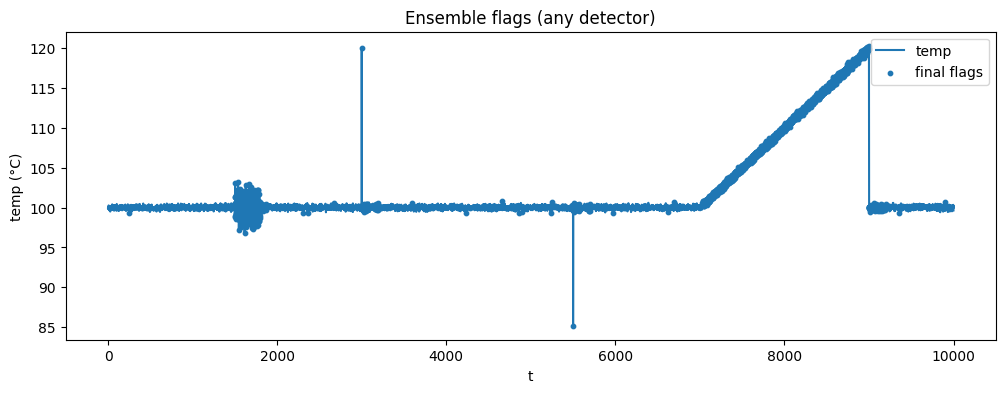

In [ ]:

plt.figure()
plt.plot(df["t"], df["temp"], label="temp")
plt.scatter(df.loc[final_flag == 1, "t"], df.loc[final_flag == 1, "temp"], s=10, label="final flags", marker="o", color = "red")
plt.title("Ensemble flags (any detector)")
plt.xlabel("t"); plt.ylabel("temp (°C)"); plt.legend(); plt.show()


## 5) Save artifact

In [33]:

out_dir = "../data/processed"
os.makedirs(out_dir, exist_ok=True)

out = df.copy()
out["flag_drift"] = drift_pred
out["flag_jitter"] = jitter_pred
out["flag_final"] = final_flag

csv_path = os.path.join(out_dir, "drift_jitter_predictions.csv")
out.to_csv(csv_path, index=False)
csv_path


'../data/processed\\drift_jitter_predictions.csv'